# Basic multi-agent simulation with steric interactions

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any
import random as rm

from matplotlib.colors import Normalize
import matplotlib.cm as cm

import importlib
# Function for plots
import plotFns as pF
# Parameters in the model
import prmts as pR

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Agents walking along semi-circular track by following pheromone</a>

In [43]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 2500 #number of steps of each run
        self.nAgnts = 5 #number of agents
        # self.nEpchs = 250 #number of epochs
        self.a = 1.0 #radius of semi-circle
        self.nIntSteps = int(0.5*self.nSteps) #number of steps of intrinsic policy
        
        # Pheromone parameters
        self.nMsh = 500 #number of points in 
        self.kM = 1 #rate of pheromone decay
        self.kP = 0.1 #rate of pheromone generation
        
        # Agent dynamics parameters
        self.pt = 0.08 #initial pheromone trail thickness
        self.sz = 0.02 #agent size (radius)
        self.dt = 1e-2 #time-step size
        self.l = 0.5e-2 #length travelled in 1 time-step
        self.vo = self.l/self.dt #effective speed of motion
        self.nu = 50 #orientation relaxation rate (s^-1)
        self.diff = 50e-1 #noise diffusion coefficient (s^-1)
        self.pe = self.diff/self.nu #peclet number
        
        # Reward parameters
        self.phiSt = np.pi/8 #reward goes as exp(-\phi/\phiSt)
        self.sigma = 0.1 #radius of region near target within which agent succeeds
        self.nPtn = 40 #number of division of \phi over which value function is define
        
        # Initial conditions
        phiInit = np.random.uniform(0, np.pi, self.nAgnts)
        self.rInit = self.a*np.array([np.cos(phiInit), np.sin(phiInit)])
        # self.rInit = np.array([self.a + np.random.uniform(-self.pt, self.pt), 0.0]) #initial location of agent
        self.tgt = np.array([-self.a, 0.0]) #target location of agent
        self.strt = np.array([self.a, 0.0]) #initial location of agent
        # self.thetInit = 0.5*np.pi #initial orientation of agent
        self.thetInit = np.random.uniform(0, 2*np.pi, self.nAgnts)
        # self.tgtPhi = 0.0 #target orientation from current location

# Pheromone initial condition and class
p = params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])

In [50]:
phm = phrmn(cInit)
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi*self.dirCtrl + np.random.uniform(-np.pi/5, np.pi/5, p.nAgnts)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        
        #Makes sure that agent is within pheromone region
        fInd = np.where(np.linalg.norm(self.r, axis=0) > (p.a+p.pt-p.l))       
        if np.size(fInd) > 0:
            self.thet[fInd] = self.thet[fInd] + self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])
        fInd = np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt+p.l))
        if np.size(np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt))) > 0:    
            self.thet[fInd] = self.thet[fInd] - self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])

        #Checks if target is reached and flip direction of motion
        clsChk = np.array([self.r[0][:] - p.tgt[0], self.r[1][:] - p.tgt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = -1.
        #Checks if home is reached and flip direction of motion
        clsChk = np.array([self.r[0][:] - p.strt[0], self.r[1][:] - p.strt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = 1.
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal(p.nAgnts)
    
    def repel(self, ptr):
        delta = (self.r[..., np.newaxis] - self.r[:, np.newaxis]).T
        distances = np.linalg.norm(delta, axis=-1)
        fInd = np.where(np.triu(distances) == 0.)
        distances[fInd] = 10.
        fInd = np.where(distances < (4*p.sz))
        fInd = np.unique(np.array(fInd).flatten())
        self.thet[fInd] += np.pi/2
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])

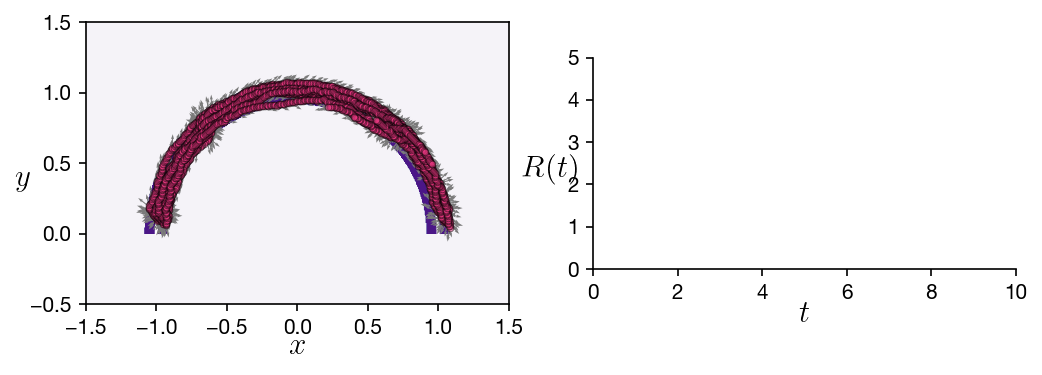

--- 0.3293759822845459 seconds ---


In [55]:
p = params()
ag = agent(p)

start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])

phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
for ind in range(p.nSteps):
    # if ind < p.nIntSteps:
    ag.intPolicy(p)
    ag.repel(p)
    # elif ind == p.nIntSteps:
    #     tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
    #     p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
    #     ag.ouPolicy(p)
    # else:
    #     ag.ouPolicy(p)
    # ag.sTrl += p.l
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))

importlib.reload(pF)
fix, ax = pF.plotDefMul(p, xphm, yphm, phm)
pF.plotMultAgt(fix, ax, p, rxFull, ryFull, phxFull, phyFull, 0.5)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [56]:
importlib.reload(pF)
pF.plotVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull)

In [58]:
! rm Multi*.png

In [57]:
! rm Check.mp4
! ffmpeg -r 10 -i "Multi%d.png" -c:v libx264 -vf fps=20 -pix_fmt yuv420p ./Check.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

 ## <a class="anchor" id="second-bullet">Setting up value function update</a>